In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro import infer

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd

In [5]:
from numpyro import distributions as dist
from antiglitch import CplxNormal

In [6]:
import antiglitch
antiglitch.utils.datadir = '/home/andrew.lundgren/src/antiglitch/notebooks/data/'
from antiglitch import freqs, extract_glitch, fsignal, to_fd, glitch_model
from antiglitch import rfft, irfft

In [7]:
numpyro.set_host_device_count(1) # Use 4 cores if available

In [8]:
ml_key = {'tomte': 'Tomte', 'blip' : 'Blip', 'koi' : 'Koi_Fish', 'lowblip' : 'Blip_Low_Frequency'}

In [9]:
df = pd.read_json('../data/all_PE.json')

In [10]:
def new_model(freqs, invasd, data=None):
    """Reparamaterised physical model"""
    amp_r = numpyro.sample("amp_r", dist.Normal(0, 200))
    amp_i = numpyro.sample("amp_i", dist.Normal(0, 200))
    tx = numpyro.sample("t_", dist.Beta(2, 2))
    t = numpyro.deterministic("time", 0.05*(2.*tx-1.))
    f0 = numpyro.sample('f0', dist.LogUniform(10., 400.))
    gbw = numpyro.sample('gbw', dist.LogUniform(0.25, 8.))

    with numpyro.plate("data", len(data)):
        numpyro.sample("y", CplxNormal((amp_r+1.j*amp_i)*jnp.exp(-2.j*jnp.pi*t*freqs)*invasd*fsignal(freqs, f0, gbw), 0.5), obs=data)

In [37]:
# Define Bayesian sampler
sampler = infer.MCMC(
    infer.NUTS(glitch_model, init_strategy=infer.init_to_sample),
    num_warmup=2000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,
    jit_model_args=True,
)

In [38]:
key = ('L1', 'blip', 100)
snip1 = antiglitch.Snippet(*key)
snip2 = antiglitch.Snippet(*key)

invasd = snip1.invasd
fglitch = to_fd(snip1.whts)

In [39]:
sampler.run(jax.random.PRNGKey(0), freqs = freqs[1:], invasd = invasd[1:], data=fglitch[1:])

sample: 100%|██████████| 3000/3000 [00:58<00:00, 50.98it/s, 1023 steps of size 1.40e-03. acc. prob=0.95]


In [40]:
itrace = az.from_numpyro(sampler)
summ = az.summary(itrace, kind='stats')
inf_data = itrace
inf = {key: float(np.mean(inf_data.posterior[key]))
        for key in ['amp_r', 'amp_i', 'f0','gbw','time']}
cpamp = inf['amp_r']+1.j*inf['amp_i']
inf['amp'] = np.abs(cpamp)
inf['phase'] = np.angle(cpamp)

In [41]:
inf

{'amp_r': 87.62957763671875,
 'amp_i': -15.252192497253418,
 'f0': 101.76445007324219,
 'gbw': 0.362592488527298,
 'time': 5.6749588111415505e-05,
 'amp': 88.9470193585091,
 'phase': -0.17232667697184162}

In [47]:
sampler.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     amp_i    -15.25      1.28    -15.27    -17.50    -13.22    172.10      1.01
     amp_r     87.63      1.69     87.62     84.72     90.36     19.14      1.25
        f0    101.76      9.17    101.99     86.21    115.74     16.82      1.30
       gbw      0.36      0.02      0.36      0.32      0.40     20.81      1.23
      time      0.00      0.00      0.00      0.00      0.00    247.92      1.02

Number of divergences: 0


In [48]:
df.query(f"ifo == '{key[0]}' and ml_label == '{ml_key[key[1]]}' and num == {key[2]}")

,amp_r,amp_i,frequency,gbw,time,amp_r_sd,amp_i_sd,f0_sd,gbw_sd,time_sd,amp,phase,snr,power,residual,peak_frequency,ifo,ml_label,num
1235,87.351,-15.04,103.394,0.366,-0.785,1.383,1.304,7.272,0.021,0.0,88.636329,-0.170507,80.157764,13.918705,1.384208,177.207474,L1,Blip,100


In [49]:
snip1.set_infer(inf)
snip2.set_infer(f"ifo == {key[0]} and ml_label == {ml_key[key[1]]} and num == {key[2]}")

array([[<AxesSubplot: title={'center': 'amp_i'}>,
        <AxesSubplot: title={'center': 'amp_i'}>],
       [<AxesSubplot: title={'center': 'amp_r'}>,
        <AxesSubplot: title={'center': 'amp_r'}>],
       [<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f0'}>],
       [<AxesSubplot: title={'center': 'gbw'}>,
        <AxesSubplot: title={'center': 'gbw'}>],
       [<AxesSubplot: title={'center': 'time'}>,
        <AxesSubplot: title={'center': 'time'}>]], dtype=object)

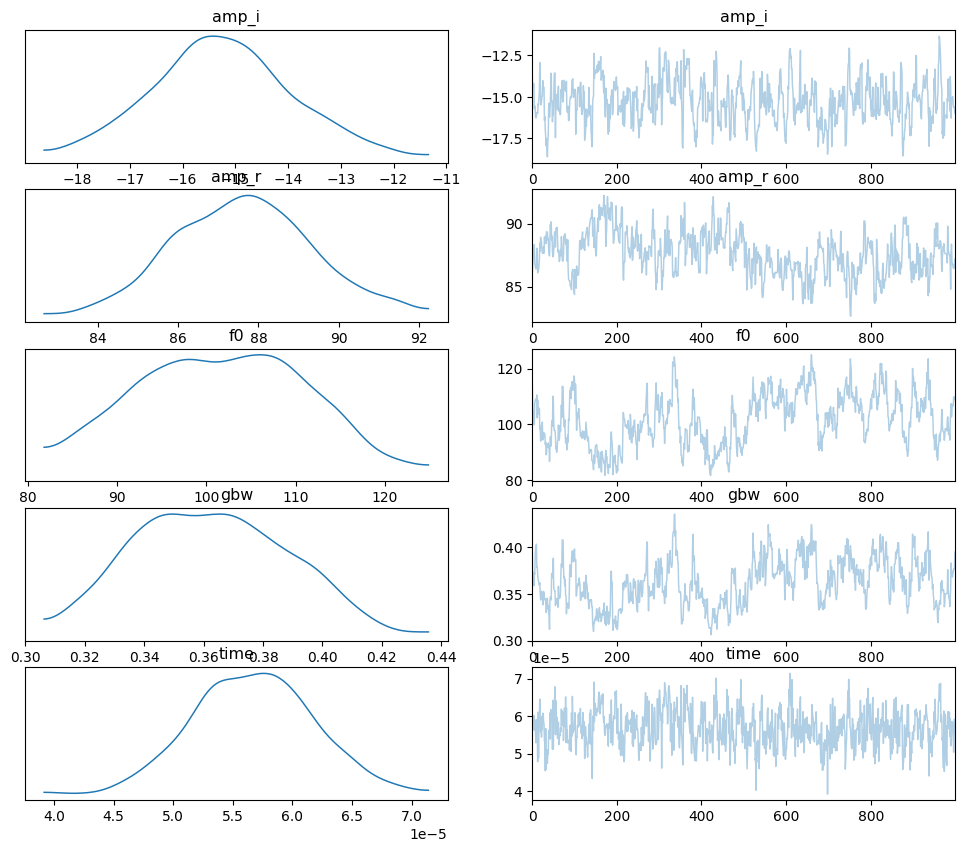

In [50]:
az.plot_trace(itrace)

array([[<AxesSubplot: title={'center': 'amp_i'}>,
        <AxesSubplot: title={'center': 'amp_r'}>,
        <AxesSubplot: title={'center': 'f0'}>],
       [<AxesSubplot: title={'center': 'gbw'}>,
        <AxesSubplot: title={'center': 'time'}>, <AxesSubplot: >]],
      dtype=object)

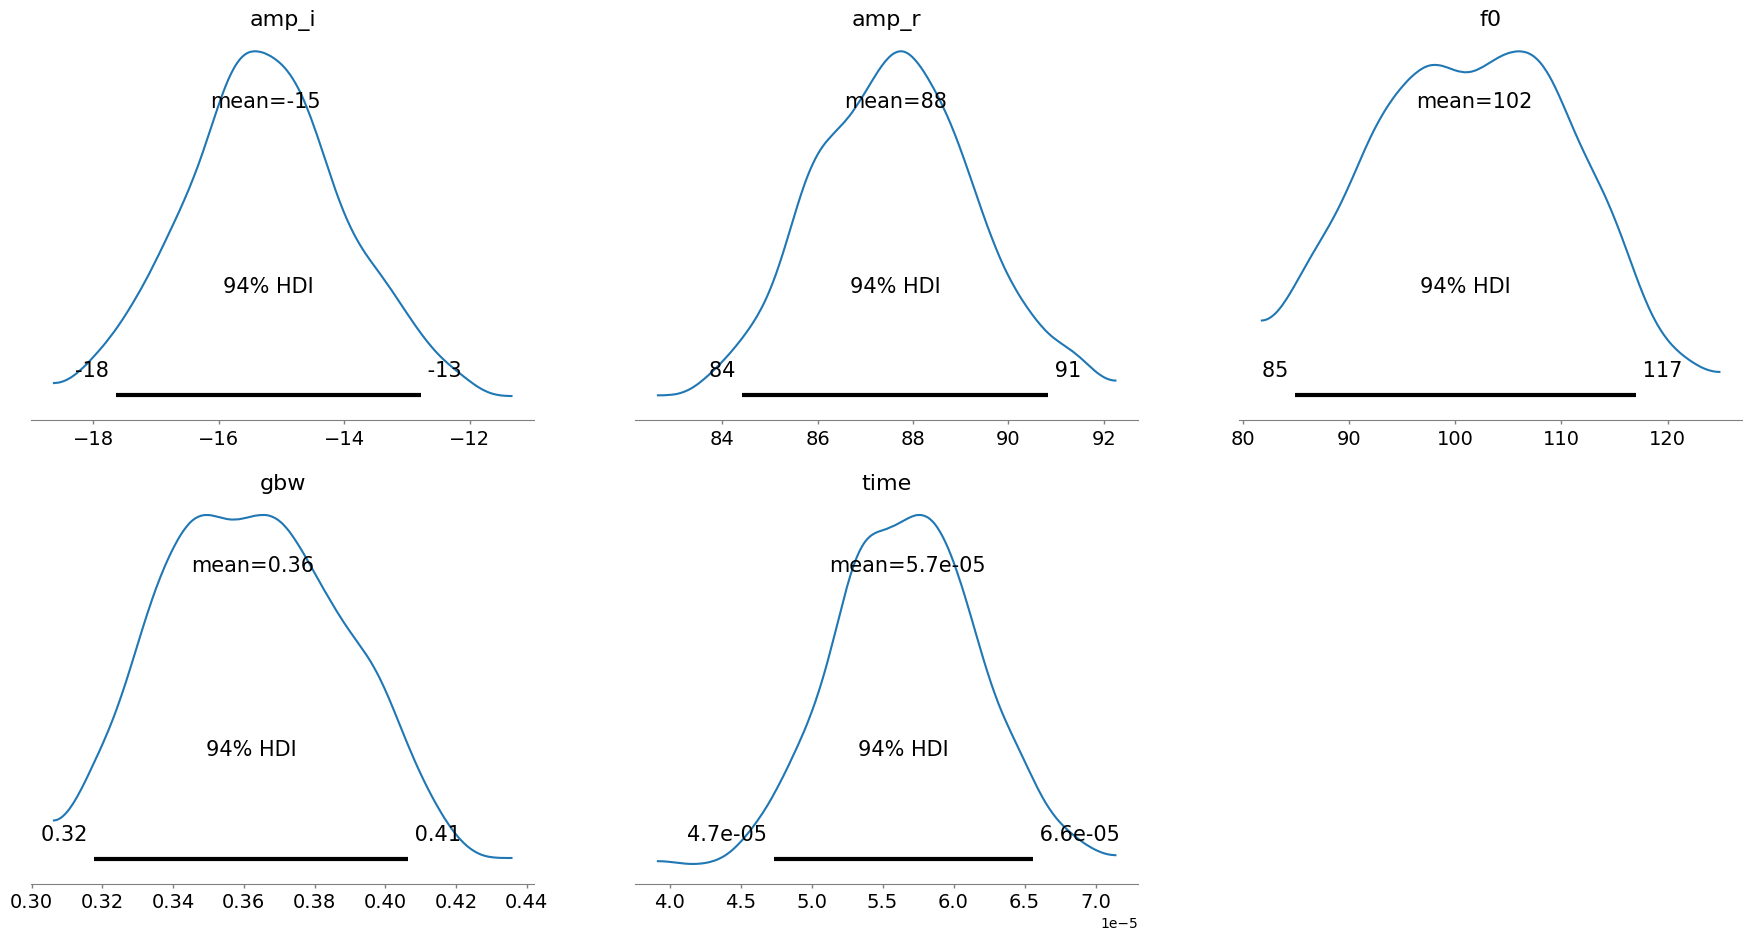

In [51]:
az.plot_posterior(itrace)

In [52]:
summ

,mean,sd,hdi_3%,hdi_97%
amp_i,-15.252,1.283,-17.642,-12.786
amp_r,87.630,1.691,84.410,90.832
f0,101.764,9.171,84.977,117.002
gbw,0.363,0.025,0.318,0.406
time,0.000,0.000,0.000,0.000


(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

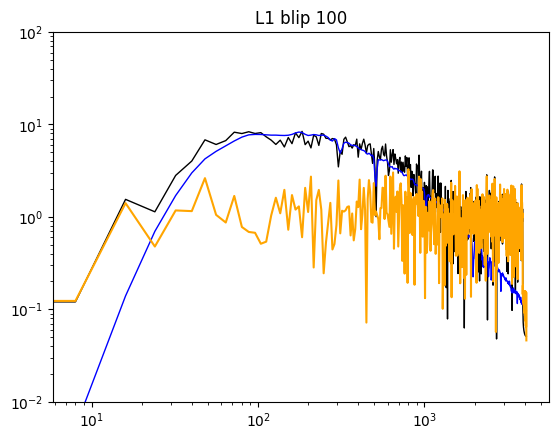

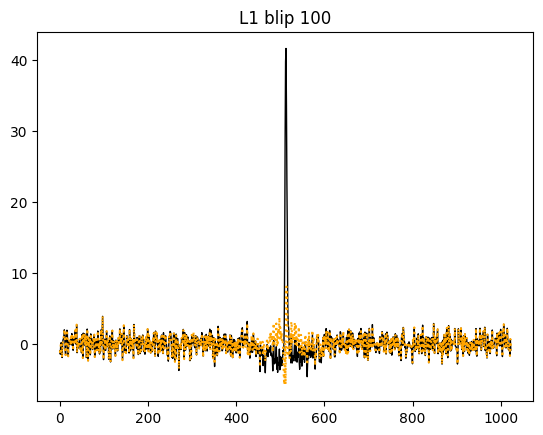

In [53]:
snip1.plot()

TypeError: antiglitch.model.fglitch_from_sample() argument after ** must be a mapping, not str

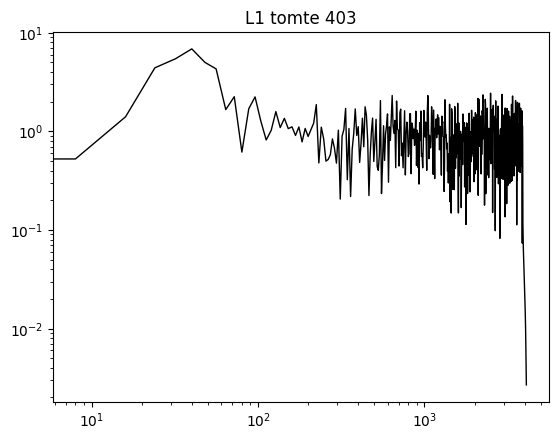

In [25]:
snip2.plot()

In [82]:
summ

,mean,sd,hdi_3%,hdi_97%
amp_i,897.323,111.298,698.108,1122.942
amp_r,184.492,110.621,-35.126,372.492
f0,18.882,2.051,14.974,22.630
gbw,2.756,0.452,1.942,3.576
time,0.009,0.003,0.005,0.014


In [46]:
pkl_to_infer(pkl[key])

{'amp_r': -1159.109,
 'amp_i': 74.605,
 'f0': 15.775,
 'gbw': 1.418,
 'time': -0.797}

In [14]:
glitch1 = fsignal(freqs, 14., 0.78)

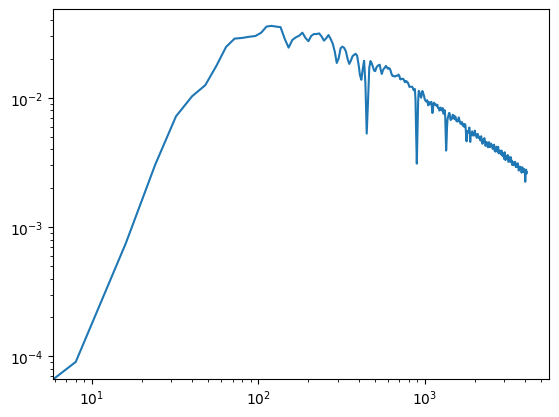

In [12]:
plt.loglog(freqs, invasd)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

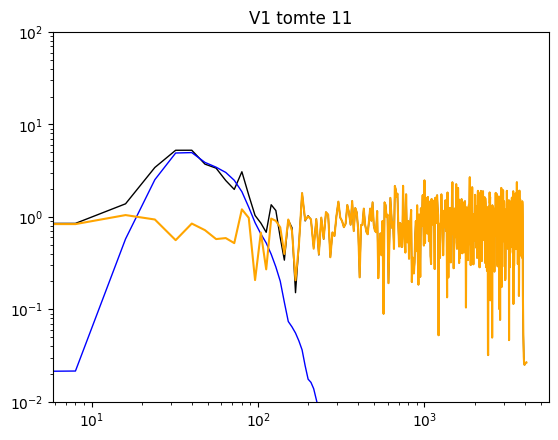

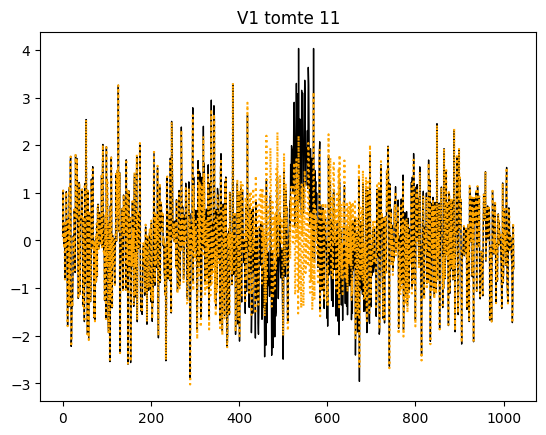

In [22]:
snip.set_infer(inf)


In [13]:
# An attempt at finding the MAP

num_svi_steps = 2000
from numpyro.infer import SVI, Trace_ELBO, autoguide
optimizer = numpyro.optim.Adam(step_size=1e-3)
guide = autoguide.AutoDelta(glitch_model)
svi = SVI(glitch_model, guide, optimizer, loss=Trace_ELBO())
svi_result = svi.run(jax.random.PRNGKey(0), num_svi_steps, freqs[1:], invasd[1:], data=fglitch[1:])
params, losses = svi_result.params, svi_result.losses

100%|██████████| 2000/2000 [00:01<00:00, 1047.41it/s, init loss: 4112.2671, avg. loss [1901-2000]: 1895.7081]


In [4]:
jax.__file__

'/home/andrew.lundgren/.conda/envs/jax/lib/python3.9/site-packages/jax/__init__.py'

In [ ]:
def test(x, *args, **kwargs):
    print(x)
    print(args)
    print(kwargs)

In [ ]:
test(0, 1, 2, a = 3, b = 4)

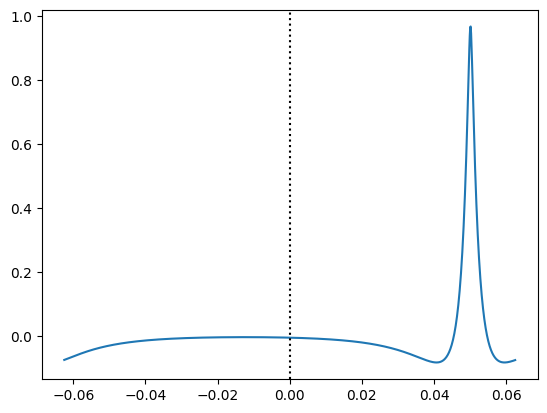

In [18]:
t = 0.05*(2*3.14159)
plt.plot(np.linspace(-0.0625, 0.0625, 1024), np.roll(irfft(jnp.exp(-1.j*t*freqs)*fsignal(freqs, 30., 1.)), 1024//2))
plt.axvline(0., c='k', ls=':')

In [10]:
freqs[1]

Array(8., dtype=float32)